In [0]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

In [0]:
# # Download the MNIST fashion dataset
# !wget wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8,gu;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/2243/9243/fashionmnist.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1565064370&Signature=DF%2FEZ9PSQRlQbrEnyUUwAqtn6Dr6ltNKR2Pkwv4sESxmtW7%2B2FUUw76q0U5Fe3ff6%2Fckv0bCBUGQuv%2BvM406LkbNdC6F060oiyTQ3SmESAAoAh1Hg10Xpv6%2BRYteLBZf%2BUZbT1%2BNA8Klrmj2nawQbcWwdLhKvrWvbDRHYRH6jmK6zFjBviXx%2BjQLsRM%2BufMFQ5ZWefYchFcYsoFvknvrPLho8ExzHoT3C44%2B%2FvuKkKZT2yjUCId8KqoDT1nNdjpPUoFSViZGo2GpKhU1XbUgfQx5mOaopAzK%2BMX8UjofSFFOlR0Qmz43NGYlePyXttVvvzVh42U%2FP5goKrrtWFZxuA%3D%3D" -O "fashionmnist.zip" -c
# !unzip fashionmnist.zip
# !rm -rf fashionmnist.zip t10k-images-idx3-ubyte t10k-labels-idx1-ubyte train-images-idx3-ubyte train-labels-idx1-ubyte sample_data

In [0]:
def get_data_from_csv(csv_file, label_header_name):
        data_frame = pd.read_csv(csv_file)
        X = data_frame.drop(label_header_name, axis = 1)
        Y = data_frame[label_header_name]
        X, Y = np.array(X), np.array(Y)
        return X.T, Y.reshape(1, -1)

def get_one_hot_encoding(array, num_classes):
    return np.squeeze(np.eye(num_classes)[array]).T

def normalize(array):
    return array / 255.0

In [127]:
num_classes = 10
X_train, Y_train = get_data_from_csv(csv_file='fashion-mnist_train.csv', label_header_name = 'label')
X_test, Y_test = get_data_from_csv(csv_file='fashion-mnist_test.csv', label_header_name = 'label')
X_train, X_test = normalize(X_train), normalize(X_test)
Y_train, Y_test = get_one_hot_encoding(Y_train, num_classes), get_one_hot_encoding(Y_test, num_classes)
print (f'X_train shape = {X_train.shape}')
print (f'Y_test shape = {Y_test.shape}')
print (f'X_test shape = {X_train.shape}')
print (f'Y_test shape = {Y_test.shape}')
labels_map = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankel boot' 
}

X_train shape = (784, 60000)
Y_test shape = (10, 10000)
X_test shape = (784, 60000)
Y_test shape = (10, 10000)


In [0]:
# This will create placeholders for X and Y with different batch sizes (None is replacable by any size at runtime)
def create_placeholders(n_x, n_y):
    '''
        n_x = number of features
        n_y = number of classes
    '''
    X = tf.placeholder(tf.float32, [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, [n_y, None], name='Y')

    return X, Y

In [0]:
# Initialize the parameters of neural network based on given architecture
def initialize_parameters(n_x, n_y, hidden_layers):

    '''
        n_x = number of features
        n_y = number of classes
        hidden_layers = list of number of neurons in each of the hidden layers
    '''

    parameters = {}
    
    hidden_layers.insert(0, n_x)
    hidden_layers.append(n_y)
    for i in range(len(hidden_layers) - 1):
        n_layer = i + 1
        parameters['W' + str(n_layer)] = tf.get_variable('W' + str(n_layer), 
                                                         [hidden_layers[n_layer], hidden_layers[n_layer - 1]],
                                                         initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters['b' + str(n_layer)] = tf.get_variable('b' + str(n_layer), 
                                                         [hidden_layers[n_layer], 1], 
                                                         initializer = tf.zeros_initializer())
    return parameters


In [0]:
# Computes forward propagation for given data and parameters
def forward_propagation(X, parameters):

    '''
        X = input data
        parameters = weights of neural network to be learned
    '''

    Ws, bs = [], []

    for param in parameters.keys():
        if 'W' in param: Ws.append(parameters[param])
        else: bs.append(parameters[param])

    A_prev = X

    # forward propagate
    for W, b in zip(Ws, bs):
        Z = tf.add(tf.matmul(W, A_prev), b)
        A_prev = tf.nn.relu(Z)
    
    return Z

In [0]:
# Computes the costs for given forward propagation output (Z_L) and actual labels
def compute_cost(Z_L, Y):
    '''
        tf.nn.softmax_cross_entropy_with_logits expcts Z_L instead of A_L, It will apply softmax and calculate A_L. 
        Reference: https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits

        It also expects the dimention on Z_L and Y as (m, C), where m = number of examples and C is number of classes
    '''

    Z_L, Y = tf.transpose(Z_L), tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z_L, labels = Y))

    return cost

In [0]:
def get_random_minibatches(X, Y, minibatch_size = 64, seed = 0):

    # First set the seed
    np.random.seed(seed)
    m = X.shape[1]
    minibatches = []

    # Then get the permutation of indices and using that, shuffel X and Y
    permutation = list(np.random.permutation(m))
    X = X[:, permutation]
    Y = Y[:, permutation].reshape(Y.shape[0], m)

    # Now get minibatches from shuffeled X and Y
    n_complete_minibatches = math.floor(m / minibatch_size)

    # Get all complete minibatches
    for index in range(n_complete_minibatches):
        minibatch_X = X[:, index * minibatch_size : (index + 1) * minibatch_size]
        minibatch_Y = Y[:, index * minibatch_size : (index + 1) * minibatch_size]
        minibatches.append((minibatch_X, minibatch_Y))

    # Now handle the case of last incomplete minibatch
    if not (m % minibatch_size == 0):
        minibatch_X = X[:, n_complete_minibatches * minibatch_size: ]
        minibatch_Y = Y[:, n_complete_minibatches * minibatch_size: ]
        minibatches.append((minibatch_X, minibatch_Y))

    return minibatches

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [0]:
def predict(images, trained_parameters):

    Ws, bs = [], []
    parameters = {}

    for param in trained_parameters.keys():
        parameters[param] = tf.convert_to_tensor(trained_parameters[param])
    
    X = tf.placeholder(tf.float32, [images.shape[0], None], name = 'X')
    Z_L = forward_propagation(X, trained_parameters)
    
    p = tf.argmax(Z_L) # Working fine
    # p = tf.argmax(tf.nn.softmax(Z_L)) # not working if softmax is applied

    with tf.Session() as session:
        prediction = session.run(p, feed_dict={X: images})
    
    return prediction

In [0]:
# Defines neural network model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, n_epochs = 1500, minibatch_size = 64, sgd = True):

    # Initialize necessary parameters
    tf.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    costs = []

    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters(n_x, n_y, [128, 128, 128])  # list of nurons in each hidden layers
    Z_L = forward_propagation(X, parameters=parameters)
    cost = compute_cost(Z_L, Y)

    # Backpropagate
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initialize Tensorflow variables
    init = tf.global_variables_initializer()

    # Start Tensorflow session
    with tf.Session() as session:

        session.run(init)

        # Gradient descent training loop
        for epoch in range(n_epochs):

            batch_cost = 0

            # If batch gradient descent is required
            if not sgd: 
                _, batch_cost = session.run([optimizer, cost], feed_dict = {X: X_train, Y: Y_train})
            else: # else perform SGD (mini-batch gradient descent)
                n_minibatches = m // minibatch_size
                seed += 1
                minibatches = get_random_minibatches(X_train, Y_train, minibatch_size, seed)

                # Loop over all the mini batches to complete 1 epoch
                for minibatch in minibatches:

                    minibatch_X, minibatch_Y = minibatch
                    _, minibatch_cost = session.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})

                    batch_cost += minibatch_cost / n_minibatches

            if epoch % 100 == 0:
                print (f'Cost after {epoch}: {batch_cost}')
            if epoch % 5 == 0:
                costs.append(batch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = session.run(parameters)

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z_L), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    
    return parameters 

Cost after 0: 0.5471795220862323
Cost after 100: 0.025768067277997738
Cost after 200: 0.01527737170309381
Cost after 300: 0.016043536441956188


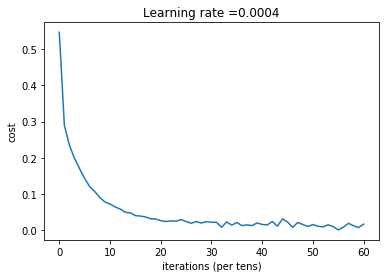

Train Accuracy: 0.99876666
Test Accuracy: 0.9016


In [43]:
# Train the model with stochastic gradient descent with minibatch size 64
sgd_parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0004, n_epochs=301, minibatch_size = 64, sgd = True)

Cost after 0: 2.3151276111602783
Cost after 100: 0.44193437695503235
Cost after 200: 0.35051223635673523
Cost after 300: 0.30339133739471436
Cost after 400: 0.2671626806259155
Cost after 500: 0.2400396317243576
Cost after 600: 0.22727961838245392
Cost after 700: 0.20063602924346924
Cost after 800: 0.1882523149251938
Cost after 900: 0.17210930585861206
Cost after 1000: 0.15840016305446625
Cost after 1100: 0.1470840722322464
Cost after 1200: 0.13805793225765228
Cost after 1300: 0.129301980137825
Cost after 1400: 0.12407298386096954
Cost after 1500: 0.11397857218980789
Cost after 1600: 0.1045432910323143
Cost after 1700: 0.10067469626665115
Cost after 1800: 0.0920945480465889
Cost after 1900: 0.08864093571901321
Cost after 2000: 0.09509384632110596
Cost after 2100: 0.07805415242910385
Cost after 2200: 0.07586508989334106
Cost after 2300: 0.07377352565526962
Cost after 2400: 0.06723052263259888
Cost after 2500: 0.06029225140810013


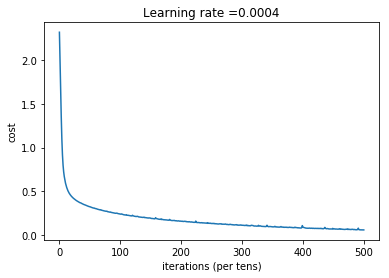

Train Accuracy: 0.9831667
Test Accuracy: 0.8849


In [114]:
# Train the same model with batch gradient descent
batch_gd_parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0004, n_epochs=2501, minibatch_size = 64, sgd = False)

In [0]:
# Note the difference between convergence rate of batch gradient and mini batch gradient descent in above calculations

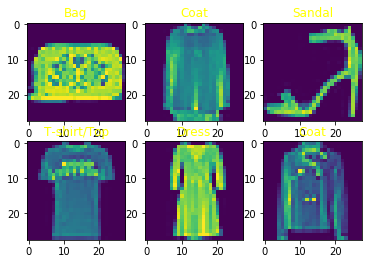

In [187]:
# Ploting few predictions on test set

count = 0
for index in range (6, 12):
  plt.subplot(2, 3, count + 1)
  plt.title(labels_map[predict(X_test[:, index].reshape(-1, 1), sgd_parameters)[0]], color = 'Yellow')
  plt.imshow(X_test[:, index].reshape(28, 28))
  count += 1
plt.show()